In [0]:
from tqdm import tqdm

In [0]:
import os 
import sys
import math 
import numpy as np
from PIL import Image

In [3]:
from keras import layers
from keras import models
from keras import callbacks
from keras import activations
from keras.layers import advanced_activations
from keras import optimizers
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [5]:
(X_train, _), (_, _) = mnist.load_data()

X_train = (X_train.astype('float32') - 127.5)/127.5
X_train = np.expand_dims(X_train, axis=len(X_train.shape))
X_train.shape

11493376/11490434 [==============================] - 1s 0us/step


(60000, 28, 28, 1)

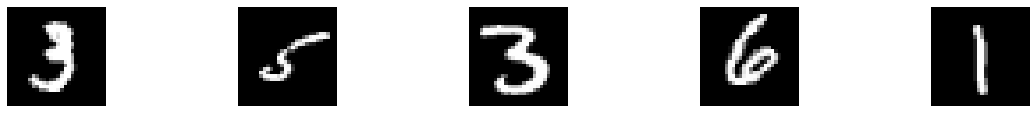

In [6]:
n=5
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i+10].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()

In [0]:
def create_conv_layer(x, output_features, apply_batch_norm=False, 
                      kernel=5, stride=2, activation=layers.Activation('relu'), name=None):
    
    # convolutional layer
    x = layers.Conv2D(
        filters=output_features, 
        kernel_size=(kernel, kernel), 
        strides=(stride, stride), 
        padding='same',
        activation=None, 
        name=name)(x) 
    
    # apply batch norm 
    if apply_batch_norm:
        x = layers.BatchNormalization()(x)
      
    # apply activation function 
    if activation:
        x = activation(x) 
    
    return x

In [0]:
def create_transpose_conv_layer(x, output_features, apply_batch_norm=False, 
                      kernel=5, stride=1, activation=layers.Activation('relu'), upscale=2, name=None):
    
    # upsample the image 
    x = layers.UpSampling2D(size=(upscale, upscale))(x)
    
    # convolutional layer
    x = layers.Conv2D(
        filters=output_features, 
        kernel_size=(kernel, kernel), 
        strides=(stride, stride), 
        padding='same', 
        activation=None, 
        name=name)(x)
    
    # apply batch norm 
    if apply_batch_norm:
        x = layers.BatchNormalization()(x)
        
    # apply activation function 
    if activation:
        x = activation(x) 
        
    return x 

In [0]:
def create_dense_layer(x, output_features, apply_batch_norm=False, 
                      activation=layers.Activation('relu'), name=None):

    x = layers.Dense(output_features, activation=None, name=name)(x) 
    
    if apply_batch_norm:
        x = layers.BatchNormalization()(x) 
        
    if activation:
        x = activation(x) 
        
    return x

In [0]:
def create_generator(latent_size=100, width=28, height=28, channels=1):
    x_input = layers.Input((latent_size,))
    
    x = create_dense_layer(x_input, 
                           7*7*128, 
                           False, 
                           advanced_activations.LeakyReLU(0.2), name='g_dense_1')
    
    x = layers.Reshape((7, 7, 128))(x)    
    
    x = create_transpose_conv_layer(x, 
                                    64, 
                                    False, 
                                    activation=advanced_activations.LeakyReLU(0.2), name='g_conv_1')
    
    x = create_transpose_conv_layer(x, 
                                    1, 
                                    False, 
                                    activation=layers.Activation('tanh'), name='g_conv_2')
    
    return models.Model(inputs=x_input, outputs=x)    

In [0]:
def create_discriminator(width=28, height=28, channels=1):
    x_input = layers.Input((width, height, channels,))    
    
    x = create_conv_layer(x_input, 
                          64, 
                          kernel=5, 
                          stride=2, 
                          apply_batch_norm=False, 
                          activation=advanced_activations.LeakyReLU(0.2), 
                          name='d_conv_1')
    
    x = create_conv_layer(x_input, 
                          128, 
                          kernel=5, 
                          stride=2, 
                          apply_batch_norm=False, 
                          activation=advanced_activations.LeakyReLU(0.2), 
                          name='d_conv_2')
    
    x = layers.Flatten()(x) 
    
    x = create_dense_layer(x, 
                           256, 
                           False, 
                           advanced_activations.LeakyReLU(0.2), 
                           name='d_dense_1')
    
    x = create_dense_layer(x, 
                           1, 
                           False, 
                           layers.Activation('sigmoid'), 
                           name='d_dense_2')
    
    return models.Model(inputs=x_input, outputs=x)

In [0]:
def create_gan(generator, discriminator, latent_size=100):
  discriminator.trainable = False
  
  x_input = layers.Input((latent_size,))
  x = generator(x_input)
  output = discriminator(x)
  
  model = models.Model(inputs=x_input, outputs=output)  

  return model

In [0]:
z_shape = 100

#batch_size = 32
batch_size = 4
epochs = 50
lr = 0.0002  # initial learning rate
b_1 = 0.5  # momentum term

In [31]:
# Load data 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
EXPORT_DIR = "/content/gdrive/My Drive/Notebooks/exports_mnist_5_samples/"
EXPORT_DIR_WEIGHTS = "/content/gdrive/My Drive/Notebooks/exports_mnist_5_weights/"

if not os.path.exists(EXPORT_DIR):
  os.mkdir(EXPORT_DIR)
  
if not os.path.exists(EXPORT_DIR_WEIGHTS):
  os.mkdir(EXPORT_DIR_WEIGHTS)

In [0]:
#!ls "/content/gdrive/My Drive/Notebooks/exports_mnist_gan_3_no_batch_norm/"

In [0]:
# Define optimizers
optimizer = optimizers.Adam(lr=lr, beta_1=b_1)
# optimizer = optimizers.RMSprop(lr=lr)
#optimizer = optimizers.SGD(lr=lr, momentum=0.5)

In [0]:
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)

generator = create_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

gan = create_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [36]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
d_conv_2 (Conv2D)            (None, 14, 14, 128)       3328      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
d_dense_1 (Dense)            (None, 256)               6422784   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
d_dense_2 (Dense)            (None, 1)                 257       
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [37]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
g_dense_1 (Dense)            (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
g_conv_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

In [0]:
# if os.path.exists('/content/gdrive/My Drive/Notebooks/exports_mnist_gan/mnist_gan_weights_checkpoint.h5'):
#   gan.load_weights('/content/gdrive/My Drive/Notebooks/exports_mnist_gan/mnist_gan_weights_checkpoint.h5')

In [0]:
# if os.path.exists('/content/gdrive/My Drive/Notebooks/exports_mnist_gan/mnist_dis_weights_checkpoint.h5'):
#   discriminator.load_weights('/content/gdrive/My Drive/Notebooks/exports_mnist_gan/mnist_dis_weights_checkpoint.h5')

In [0]:
def combine_images(generated_images):
  total,width,height = generated_images.shape[:-1]
  cols = int(math.sqrt(total))
  rows = math.ceil(float(total)/cols)
  combined_image = np.zeros((height*rows, width*cols),
                            dtype=generated_images.dtype)

  for index, image in enumerate(generated_images):
      i = int(index/cols)
      j = index % cols
      combined_image[width*i:width*(i+1), height*j:height*(j+1)] = image[:, :, 0]
  return combined_image

In [0]:
d_loss_array = []
g_loss_array = []

num_batches = int(X_train.shape[0] / batch_size)

print("-------------------")
print("Total epoch:", epochs, "Number of batches:", num_batches)
print("-------------------")

#z_pred = np.array([np.random.uniform(-1,1,z_shape) for _ in range(49)])
z_pred = np.array([np.random.normal(0.0,0.5,z_shape) for _ in range(49)])

y_g = [1] * batch_size
y_d_true = [1] * batch_size
y_d_gen = [0] * batch_size

for epoch in list(map(lambda x: x+1,range(epochs))):
  for index in range(num_batches):
    X_d_true = X_train[index*batch_size:(index+1)*batch_size]
    X_g = np.array([np.random.normal(0,0.5,z_shape) for _ in range(batch_size)])
    X_d_gen = generator.predict(X_g, verbose=0)
    
    # train discriminator
    d_loss = discriminator.train_on_batch(np.concatenate([X_d_true, X_d_gen]), np.concatenate([y_d_true, y_d_gen]))
    d_loss_array.append(d_loss)
    
    # train generator
    g_loss = gan.train_on_batch(X_g, y_g)
    g_loss_array.append(g_loss)
    
  # save generated images
  image = combine_images(generator.predict(z_pred))
  image = image*127.5 + 127.5
  Image.fromarray(image.astype(np.uint8)).save(EXPORT_DIR+"%03depoch.png" % (epoch))
  print()
  
  # save models
  generator.save(EXPORT_DIR + 'dcgan_generator.h5')
  discriminator.save(EXPORT_DIR + 'dcgan_discriminator.h5')
                                                 

-------------------
Total epoch: 50 Number of batches: 15000
-------------------
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [28]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.concatenate([a, b])

array([1, 2, 3, 4, 5, 6])

In [0]:
def save_rgb_img(img, path):
    """
    Save a rgb image
    """
    img = np.squeeze(img)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.imshow(img, interpolation='nearest', cmap='gray_r')
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("RGB Image")

    plt.savefig(path)
    plt.close()

In [0]:
def generate_images():
  z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))
  gen_images1 = generator.predict_on_batch(z_noise)
  image_index = 0
  for img in gen_images1[:20]:
    save_rgb_img(img, "/content/gdrive/My Drive/Notebooks/exports_mnist_gan_2/gen_epoch_{}_{}.png".format(epoch, image_index))
    image_index += 1

In [0]:
d_loss_array = []
g_loss_array = []

for epoch in range(1, epochs+1):
    print("Epoch ", epoch)
    
    number_of_batches = int(XTrain.shape[0] / batch_size)
  
    for index in tqdm(range(number_of_batches)):        
        # *** train discriminator *** 
        z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))
        generated_images = generator.predict_on_batch(z_noise)
        
        image_batch = XTrain[index * batch_size:(index + 1) * batch_size]        
        image_batch = np.expand_dims(image_batch, axis=-1)                
        
        x = np.concatenate([image_batch, generated_images])
        
        y_real = np.ones(batch_size) - (np.random.random_sample(batch_size) * 0.2)
        y_fake = np.random.random_sample(batch_size) * 0.1
        
        y = np.concatenate([y_real, y_fake])

        discriminator.trainable = True 
        # Train discriminator
        d_loss = discriminator.train_on_batch(x, y)
        d_loss_array.append(d_loss)
                
        # ** train gan *** 
        discriminator.trainable = False 
        z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))
        g_loss = gan.train_on_batch(z_noise, np.ones(batch_size))        
        g_loss_array.append(g_loss)
    
#     print("d_loss:", d_loss)
#     print("g_loss:", g_loss)
    
    gan.save_weights('/content/gdrive/My Drive/Notebooks/exports_mnist_gan_2/mnist_gan_weights_checkpoint.h5')
    discriminator.save_weights('/content/gdrive/My Drive/Notebooks/exports_mnist_gan_2/mnist_dis_weights_checkpoint.h5')
    
    # *** generate samples *** 
    if epoch % 10 == 0:
        #generate_images()
        z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))
        gen_images1 = generator.predict_on_batch(z_noise)
        for img in gen_images1[:2]:
            save_rgb_img(img, "/content/gdrive/My Drive/Notebooks/exports_mnist_gan_2/gen_epoch_{}.png".format(epoch))

  0%|          | 0/468 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  1%|          | 3/468 [00:00<00:23, 20.15it/s]

Epoch  1


  1%|          | 3/468 [00:00<00:17, 27.07it/s]

Epoch  2


  1%|          | 3/468 [00:00<00:16, 27.43it/s]

Epoch  3


  1%|          | 3/468 [00:00<00:16, 27.81it/s]

Epoch  4


  1%|          | 3/468 [00:00<00:16, 27.67it/s]

Epoch  5


  1%|          | 3/468 [00:00<00:16, 27.43it/s]

Epoch  6


  1%|          | 3/468 [00:00<00:17, 26.63it/s]

Epoch  7


  1%|          | 3/468 [00:00<00:16, 27.83it/s]

Epoch  8


  1%|          | 3/468 [00:00<00:16, 27.89it/s]

Epoch  9


  1%|          | 3/468 [00:00<00:16, 27.85it/s]

Epoch  10


  1%|          | 3/468 [00:00<00:16, 28.13it/s]

Epoch  11


  1%|          | 3/468 [00:00<00:16, 27.41it/s]

Epoch  12


  1%|          | 3/468 [00:00<00:16, 28.23it/s]

Epoch  13


  1%|          | 3/468 [00:00<00:16, 27.99it/s]

Epoch  14


  1%|          | 3/468 [00:00<00:16, 27.97it/s]

Epoch  15


  1%|          | 3/468 [00:00<00:16, 27.69it/s]

Epoch  16


  1%|          | 3/468 [00:00<00:16, 27.82it/s]

Epoch  17


  1%|          | 3/468 [00:00<00:16, 27.85it/s]

Epoch  18


  1%|          | 3/468 [00:00<00:16, 27.94it/s]

Epoch  19


  1%|          | 3/468 [00:00<00:16, 27.63it/s]

Epoch  20


  1%|          | 3/468 [00:00<00:16, 28.36it/s]

Epoch  21


  1%|          | 3/468 [00:00<00:16, 27.88it/s]

Epoch  22


  1%|          | 3/468 [00:00<00:16, 27.64it/s]

Epoch  23


  1%|          | 3/468 [00:00<00:16, 28.51it/s]

Epoch  24


  1%|          | 3/468 [00:00<00:16, 27.56it/s]

Epoch  25


  1%|          | 3/468 [00:00<00:16, 28.07it/s]

Epoch  26


  1%|          | 3/468 [00:00<00:16, 27.82it/s]

Epoch  27


  1%|          | 3/468 [00:00<00:16, 28.07it/s]

Epoch  28


  1%|          | 3/468 [00:00<00:16, 28.10it/s]

Epoch  29


  1%|          | 3/468 [00:00<00:16, 27.73it/s]

Epoch  30


  1%|          | 3/468 [00:00<00:16, 27.88it/s]

Epoch  31


  1%|          | 3/468 [00:00<00:16, 27.85it/s]

Epoch  32


  1%|          | 3/468 [00:00<00:16, 28.05it/s]

Epoch  33


  1%|          | 3/468 [00:00<00:16, 28.21it/s]

Epoch  34


  1%|          | 3/468 [00:00<00:16, 27.68it/s]

Epoch  35


  1%|          | 3/468 [00:00<00:16, 28.04it/s]

Epoch  36


  1%|          | 3/468 [00:00<00:16, 28.34it/s]

Epoch  37


  1%|          | 3/468 [00:00<00:16, 27.78it/s]

Epoch  38


  1%|          | 3/468 [00:00<00:16, 27.95it/s]

Epoch  39


  1%|          | 3/468 [00:00<00:16, 28.27it/s]

Epoch  40


  1%|          | 3/468 [00:00<00:17, 26.62it/s]

Epoch  41


  1%|          | 3/468 [00:00<00:16, 27.71it/s]

Epoch  42


  1%|          | 3/468 [00:00<00:16, 27.77it/s]

Epoch  43


  1%|          | 3/468 [00:00<00:17, 26.74it/s]

Epoch  44


  1%|          | 3/468 [00:00<00:18, 25.49it/s]

Epoch  45


  1%|          | 3/468 [00:00<00:17, 27.32it/s]

Epoch  46


  1%|          | 3/468 [00:00<00:16, 27.78it/s]

Epoch  47


  1%|          | 3/468 [00:00<00:16, 27.89it/s]

Epoch  48


  1%|          | 3/468 [00:00<00:16, 27.82it/s]

Epoch  49


  1%|          | 3/468 [00:00<00:16, 28.08it/s]

Epoch  50


  1%|          | 3/468 [00:00<00:16, 28.20it/s]

Epoch  51


  1%|          | 3/468 [00:00<00:16, 27.59it/s]

Epoch  52


  1%|          | 3/468 [00:00<00:16, 27.62it/s]

Epoch  53


  1%|          | 3/468 [00:00<00:16, 27.51it/s]

Epoch  54


  1%|          | 3/468 [00:00<00:17, 27.21it/s]

Epoch  55


  1%|          | 3/468 [00:00<00:17, 27.27it/s]

Epoch  56


  1%|          | 3/468 [00:00<00:17, 26.59it/s]

Epoch  57


  1%|          | 3/468 [00:00<00:17, 26.25it/s]

Epoch  58


  1%|          | 3/468 [00:00<00:17, 26.28it/s]

Epoch  59


  1%|          | 3/468 [00:00<00:17, 27.20it/s]

Epoch  60


  1%|          | 3/468 [00:00<00:17, 26.02it/s]

Epoch  61


  1%|          | 3/468 [00:00<00:16, 28.13it/s]

Epoch  62


  1%|          | 3/468 [00:00<00:16, 28.13it/s]

Epoch  63


  1%|          | 3/468 [00:00<00:16, 27.94it/s]

Epoch  64


  1%|          | 3/468 [00:00<00:16, 27.61it/s]

Epoch  65


  1%|          | 3/468 [00:00<00:16, 27.89it/s]

Epoch  66


  1%|          | 3/468 [00:00<00:16, 27.62it/s]

Epoch  67


  1%|          | 3/468 [00:00<00:17, 26.33it/s]

Epoch  68


  1%|          | 3/468 [00:00<00:17, 27.00it/s]

Epoch  69


  1%|          | 3/468 [00:00<00:16, 27.50it/s]

Epoch  70


  1%|          | 3/468 [00:00<00:16, 27.44it/s]

Epoch  71


  1%|          | 3/468 [00:00<00:16, 27.71it/s]

Epoch  72


  1%|          | 3/468 [00:00<00:16, 27.83it/s]

Epoch  73


  1%|          | 3/468 [00:00<00:16, 27.83it/s]

Epoch  74


  1%|          | 3/468 [00:00<00:16, 27.91it/s]

Epoch  75


  1%|          | 3/468 [00:00<00:16, 27.53it/s]

Epoch  76


  1%|          | 3/468 [00:00<00:16, 27.82it/s]

Epoch  77


  1%|          | 3/468 [00:00<00:16, 27.67it/s]

Epoch  78


  1%|          | 3/468 [00:00<00:16, 27.64it/s]

Epoch  79


  1%|          | 3/468 [00:00<00:16, 27.77it/s]

Epoch  80


  1%|          | 3/468 [00:00<00:16, 27.98it/s]

Epoch  81


  1%|          | 3/468 [00:00<00:16, 28.05it/s]

Epoch  82


  1%|          | 3/468 [00:00<00:16, 28.13it/s]

Epoch  83


  1%|          | 3/468 [00:00<00:16, 28.01it/s]

Epoch  84


  1%|          | 3/468 [00:00<00:17, 26.14it/s]

Epoch  85


  1%|          | 3/468 [00:00<00:16, 27.91it/s]

Epoch  86


  1%|          | 3/468 [00:00<00:16, 27.97it/s]

Epoch  87


  1%|          | 3/468 [00:00<00:16, 27.94it/s]

Epoch  88


  1%|          | 3/468 [00:00<00:16, 28.00it/s]

Epoch  89


  1%|          | 3/468 [00:00<00:16, 27.88it/s]

Epoch  90


  1%|          | 3/468 [00:00<00:16, 27.79it/s]

Epoch  91


  1%|          | 3/468 [00:00<00:16, 27.73it/s]

Epoch  92


  1%|          | 3/468 [00:00<00:17, 26.89it/s]

Epoch  93


  1%|          | 3/468 [00:00<00:16, 27.54it/s]

Epoch  94


  1%|          | 3/468 [00:00<00:16, 27.56it/s]

Epoch  95


  1%|          | 3/468 [00:00<00:16, 27.49it/s]

Epoch  96


  1%|          | 3/468 [00:00<00:16, 27.71it/s]

Epoch  97


  1%|          | 3/468 [00:00<00:16, 27.87it/s]

Epoch  98


  1%|          | 3/468 [00:00<00:16, 28.07it/s]

Epoch  99


  1%|          | 3/468 [00:00<00:16, 27.44it/s]

Epoch  100


  1%|          | 3/468 [00:00<00:16, 28.15it/s]

Epoch  101


  1%|          | 3/468 [00:00<00:17, 26.60it/s]

Epoch  102


  1%|          | 3/468 [00:00<00:17, 27.33it/s]

Epoch  103


  1%|          | 3/468 [00:00<00:16, 27.38it/s]

Epoch  104


  1%|          | 3/468 [00:00<00:16, 28.37it/s]

Epoch  105


  1%|          | 3/468 [00:00<00:16, 28.16it/s]

Epoch  106


  1%|          | 3/468 [00:00<00:16, 28.01it/s]

Epoch  107


  1%|          | 3/468 [00:00<00:16, 28.15it/s]

Epoch  108


  1%|          | 3/468 [00:00<00:16, 28.05it/s]

Epoch  109


  1%|          | 3/468 [00:00<00:16, 27.84it/s]

Epoch  110


  1%|          | 3/468 [00:00<00:16, 27.85it/s]

Epoch  111


  1%|          | 3/468 [00:00<00:16, 28.41it/s]

Epoch  112


  1%|          | 3/468 [00:00<00:16, 28.20it/s]

Epoch  113


  1%|          | 3/468 [00:00<00:16, 27.78it/s]

Epoch  114


  1%|          | 3/468 [00:00<00:16, 28.13it/s]

Epoch  115


  1%|          | 3/468 [00:00<00:16, 28.32it/s]

Epoch  116


  1%|          | 3/468 [00:00<00:16, 28.49it/s]

Epoch  117


  1%|          | 3/468 [00:00<00:16, 28.19it/s]

Epoch  118


  1%|          | 3/468 [00:00<00:17, 26.70it/s]

Epoch  119


  1%|          | 3/468 [00:00<00:16, 28.36it/s]

Epoch  120


  1%|          | 3/468 [00:00<00:16, 27.62it/s]

Epoch  121


  1%|          | 3/468 [00:00<00:16, 27.53it/s]

Epoch  122


  1%|          | 3/468 [00:00<00:16, 28.27it/s]

Epoch  123


  1%|          | 3/468 [00:00<00:16, 28.28it/s]

Epoch  124


  1%|          | 3/468 [00:00<00:16, 27.90it/s]

Epoch  125


  1%|          | 3/468 [00:00<00:16, 27.77it/s]

Epoch  126


  1%|          | 3/468 [00:00<00:16, 27.94it/s]

Epoch  127


  1%|          | 3/468 [00:00<00:16, 27.43it/s]

Epoch  128


  1%|          | 3/468 [00:00<00:16, 28.33it/s]

Epoch  129


  1%|          | 3/468 [00:00<00:16, 28.02it/s]

Epoch  130


  1%|          | 3/468 [00:00<00:16, 27.93it/s]

Epoch  131


  1%|          | 3/468 [00:00<00:16, 27.57it/s]

Epoch  132


  1%|          | 3/468 [00:00<00:16, 27.66it/s]

Epoch  133


  1%|          | 3/468 [00:00<00:16, 27.99it/s]

Epoch  134


  1%|          | 3/468 [00:00<00:16, 28.02it/s]

Epoch  135


  1%|          | 3/468 [00:00<00:16, 27.75it/s]

Epoch  136


  1%|          | 3/468 [00:00<00:16, 28.00it/s]

Epoch  137


  1%|          | 3/468 [00:00<00:16, 27.76it/s]

Epoch  138


  1%|          | 3/468 [00:00<00:16, 27.53it/s]

Epoch  139


  1%|          | 3/468 [00:00<00:16, 28.22it/s]

Epoch  140


  1%|          | 3/468 [00:00<00:16, 27.95it/s]

Epoch  141


  1%|          | 3/468 [00:00<00:16, 28.01it/s]

Epoch  142


  1%|          | 3/468 [00:00<00:16, 28.17it/s]

Epoch  143


  1%|          | 3/468 [00:00<00:16, 27.84it/s]

Epoch  144


  1%|          | 3/468 [00:00<00:16, 28.32it/s]

Epoch  145


  1%|          | 3/468 [00:00<00:16, 28.05it/s]

Epoch  146


  1%|          | 3/468 [00:00<00:16, 27.90it/s]

Epoch  147


  1%|          | 3/468 [00:00<00:16, 28.22it/s]

Epoch  148


  1%|          | 3/468 [00:00<00:16, 27.92it/s]

Epoch  149


  1%|          | 3/468 [00:00<00:16, 27.98it/s]

Epoch  150


  1%|          | 3/468 [00:00<00:16, 27.91it/s]

Epoch  151


  1%|          | 3/468 [00:00<00:16, 28.30it/s]

Epoch  152


  1%|          | 3/468 [00:00<00:16, 27.99it/s]

Epoch  153


  1%|          | 3/468 [00:00<00:16, 27.81it/s]

Epoch  154


  1%|          | 3/468 [00:00<00:16, 27.91it/s]

Epoch  155


  1%|          | 3/468 [00:00<00:16, 27.89it/s]

Epoch  156


  1%|          | 3/468 [00:00<00:16, 27.91it/s]

Epoch  157


  1%|          | 3/468 [00:00<00:16, 28.17it/s]

Epoch  158


  1%|          | 3/468 [00:00<00:16, 27.73it/s]

Epoch  159


  1%|          | 3/468 [00:00<00:16, 28.03it/s]

Epoch  160


  1%|          | 3/468 [00:00<00:17, 27.32it/s]

Epoch  161


  1%|          | 3/468 [00:00<00:16, 28.18it/s]

Epoch  162


  1%|          | 3/468 [00:00<00:16, 27.66it/s]

Epoch  163


  1%|          | 3/468 [00:00<00:16, 28.09it/s]

Epoch  164


  1%|          | 3/468 [00:00<00:16, 28.01it/s]

Epoch  165


  1%|          | 3/468 [00:00<00:16, 27.80it/s]

Epoch  166


  1%|          | 3/468 [00:00<00:16, 27.66it/s]

Epoch  167


  1%|          | 3/468 [00:00<00:16, 27.86it/s]

Epoch  168


  1%|          | 3/468 [00:00<00:16, 28.34it/s]

Epoch  169


  1%|          | 3/468 [00:00<00:17, 26.13it/s]

Epoch  170


  1%|          | 3/468 [00:00<00:16, 27.76it/s]

Epoch  171


  1%|          | 3/468 [00:00<00:16, 27.87it/s]

Epoch  172


  1%|          | 3/468 [00:00<00:16, 27.83it/s]

Epoch  173


  1%|          | 3/468 [00:00<00:16, 27.94it/s]

Epoch  174


  1%|          | 3/468 [00:00<00:17, 27.15it/s]

Epoch  175


  1%|          | 3/468 [00:00<00:16, 27.86it/s]

Epoch  176


  1%|          | 3/468 [00:00<00:16, 27.92it/s]

Epoch  177


  1%|          | 3/468 [00:00<00:16, 28.29it/s]

Epoch  178


  1%|          | 3/468 [00:00<00:16, 27.98it/s]

Epoch  179


  1%|          | 3/468 [00:00<00:17, 27.07it/s]

Epoch  180


  1%|          | 3/468 [00:00<00:16, 27.70it/s]

Epoch  181


  1%|          | 3/468 [00:00<00:16, 28.17it/s]

Epoch  182


  1%|          | 3/468 [00:00<00:16, 28.04it/s]

Epoch  183


  1%|          | 3/468 [00:00<00:16, 28.02it/s]

Epoch  184


  1%|          | 3/468 [00:00<00:16, 27.51it/s]

Epoch  185


  1%|          | 3/468 [00:00<00:16, 27.99it/s]

Epoch  186


  1%|          | 3/468 [00:00<00:16, 28.10it/s]

Epoch  187


  1%|          | 3/468 [00:00<00:16, 27.72it/s]

Epoch  188


  1%|          | 3/468 [00:00<00:16, 27.82it/s]

Epoch  189


  1%|          | 3/468 [00:00<00:16, 28.31it/s]

Epoch  190


  1%|          | 3/468 [00:00<00:16, 28.17it/s]

Epoch  191


  1%|          | 3/468 [00:00<00:16, 27.75it/s]

Epoch  192


  1%|          | 3/468 [00:00<00:17, 26.31it/s]

Epoch  193


  1%|          | 3/468 [00:00<00:17, 26.31it/s]

Epoch  194


  1%|          | 3/468 [00:00<00:16, 27.75it/s]

Epoch  195


  1%|          | 3/468 [00:00<00:16, 27.71it/s]

Epoch  196


  1%|          | 3/468 [00:00<00:16, 27.92it/s]

Epoch  197


  1%|          | 3/468 [00:00<00:16, 28.07it/s]

Epoch  198


  1%|          | 3/468 [00:00<00:17, 26.99it/s]

Epoch  199


  1%|          | 3/468 [00:00<00:16, 27.77it/s]

Epoch  200


  1%|          | 3/468 [00:00<00:16, 27.68it/s]

Epoch  201


  1%|          | 3/468 [00:00<00:16, 27.58it/s]

Epoch  202


  1%|          | 3/468 [00:00<00:16, 27.66it/s]

Epoch  203


  1%|          | 3/468 [00:00<00:16, 27.82it/s]

Epoch  204


  1%|          | 3/468 [00:00<00:17, 27.10it/s]

Epoch  205


  1%|          | 3/468 [00:00<00:16, 28.01it/s]

Epoch  206


  1%|          | 3/468 [00:00<00:16, 27.93it/s]

Epoch  207


  1%|          | 3/468 [00:00<00:16, 27.81it/s]

Epoch  208


  1%|          | 3/468 [00:00<00:16, 27.92it/s]

Epoch  209


  1%|          | 3/468 [00:00<00:16, 27.42it/s]

Epoch  210


  1%|          | 3/468 [00:00<00:17, 26.59it/s]

Epoch  211


  1%|          | 3/468 [00:00<00:17, 26.17it/s]

Epoch  212


  1%|          | 3/468 [00:00<00:17, 27.05it/s]

Epoch  213


  1%|          | 3/468 [00:00<00:16, 28.57it/s]

Epoch  214


  1%|          | 3/468 [00:00<00:16, 28.23it/s]

Epoch  215


  1%|          | 3/468 [00:00<00:16, 27.65it/s]

Epoch  216


  1%|          | 3/468 [00:00<00:16, 28.71it/s]

Epoch  217


  1%|          | 3/468 [00:00<00:17, 27.26it/s]

Epoch  218


  1%|          | 3/468 [00:00<00:17, 26.89it/s]

Epoch  219


  1%|          | 3/468 [00:00<00:16, 28.23it/s]

Epoch  220


  1%|          | 3/468 [00:00<00:16, 28.15it/s]

Epoch  221


  1%|          | 3/468 [00:00<00:16, 28.19it/s]

Epoch  222


  1%|          | 3/468 [00:00<00:16, 27.87it/s]

Epoch  223


  1%|          | 3/468 [00:00<00:16, 27.89it/s]

Epoch  224


  1%|          | 3/468 [00:00<00:16, 28.12it/s]

Epoch  225


  1%|          | 3/468 [00:00<00:16, 28.32it/s]

Epoch  226


  1%|          | 3/468 [00:00<00:16, 27.72it/s]

Epoch  227


  1%|          | 3/468 [00:00<00:16, 27.92it/s]

Epoch  228


  1%|          | 3/468 [00:00<00:16, 28.24it/s]

Epoch  229


  1%|          | 3/468 [00:00<00:16, 27.76it/s]

Epoch  230


  1%|          | 3/468 [00:00<00:16, 27.81it/s]

Epoch  231


  1%|          | 3/468 [00:00<00:16, 27.81it/s]

Epoch  232


  1%|          | 3/468 [00:00<00:16, 27.86it/s]

Epoch  233


  1%|          | 3/468 [00:00<00:16, 28.32it/s]

Epoch  234


  1%|          | 3/468 [00:00<00:16, 27.45it/s]

Epoch  235


  1%|          | 3/468 [00:00<00:17, 26.84it/s]

Epoch  236


  1%|          | 3/468 [00:00<00:17, 26.99it/s]

Epoch  237


  1%|          | 3/468 [00:00<00:16, 28.24it/s]

Epoch  238


  1%|          | 3/468 [00:00<00:17, 27.22it/s]

Epoch  239


  1%|          | 3/468 [00:00<00:17, 26.79it/s]

Epoch  240


  1%|          | 3/468 [00:00<00:16, 28.03it/s]

Epoch  241


  1%|          | 3/468 [00:00<00:17, 27.17it/s]

Epoch  242


  1%|          | 3/468 [00:00<00:16, 28.12it/s]

Epoch  243


  1%|          | 3/468 [00:00<00:16, 27.91it/s]

Epoch  244


  1%|          | 3/468 [00:00<00:17, 27.01it/s]

Epoch  245


  1%|          | 3/468 [00:00<00:16, 27.65it/s]

Epoch  246


  1%|          | 3/468 [00:00<00:17, 27.19it/s]

Epoch  247


  1%|          | 3/468 [00:00<00:16, 28.10it/s]

Epoch  248


  1%|          | 3/468 [00:00<00:16, 27.44it/s]

Epoch  249


  1%|          | 3/468 [00:00<00:16, 28.12it/s]

Epoch  250


  1%|          | 3/468 [00:00<00:16, 28.12it/s]

Epoch  251


  1%|          | 3/468 [00:00<00:16, 28.01it/s]

Epoch  252


  1%|          | 3/468 [00:00<00:16, 27.73it/s]

Epoch  253


  1%|          | 3/468 [00:00<00:16, 27.99it/s]

Epoch  254


  1%|          | 3/468 [00:00<00:16, 27.66it/s]

Epoch  255


  1%|          | 3/468 [00:00<00:16, 28.11it/s]

Epoch  256


  1%|          | 3/468 [00:00<00:16, 28.16it/s]

Epoch  257


  1%|          | 3/468 [00:00<00:16, 28.21it/s]

Epoch  258


  1%|          | 3/468 [00:00<00:16, 27.59it/s]

Epoch  259


 17%|█▋        | 81/468 [00:02<00:13, 27.97it/s]

In [53]:
np.random.normal(0,0.5,100)

array([-0.30479498, -0.04781905, -0.58982528, -0.0856768 , -0.79420526,
       -0.14662268,  0.23760706, -0.99880224,  0.08495879, -1.12992415,
        0.32144725,  0.35524205, -0.40133707,  0.02509822, -0.24034346,
       -0.9439794 ,  0.01223737, -0.76501903,  0.29853895, -1.15963378,
       -0.15990264,  0.02691492, -0.72875833, -0.05602724, -0.46949571,
        0.16322543, -0.27831954, -0.18893298,  0.03043214,  0.19264321,
       -0.60658783, -0.16780432,  0.30148985,  0.62487804, -0.19764769,
       -0.08004311,  0.35219642, -0.2694235 , -0.33462224,  0.22143172,
        0.17455474, -0.8183204 ,  0.08374811, -0.29790918, -0.48841535,
       -0.127108  , -0.10130079,  0.33459623,  0.14790698,  0.73556625,
       -0.05196908,  0.05111316, -0.07778188, -0.05164113,  1.04243831,
        0.74053068,  0.5366459 , -0.14636509, -0.26397675,  0.44909263,
       -0.78133778,  0.17276059,  0.83313374,  0.2281152 ,  0.18987381,
       -0.53061638, -0.23725236, -0.3988584 ,  0.19980817, -1.02

[-1.1512663, 0.75990146, -0.07928658, 0.89759046, -1.0752685, -0.04958897, -0.58323795, -0.9667478, -0.020348074, -0.10809761, 0.109084845, 0.44082952, -0.29703644, -1.21371, 0.8394581, 0.7864342, 0.24612193, -1.5498476, -0.5397871, -0.25567988, 0.94975275, -0.5746415, 0.18157484, -0.43186602, 0.5442024, 0.100124024, 0.148687, 0.8796696, 1.060995, 1.3052207, 0.5313458, 0.20374165, -2.0176451, 0.15763642, 0.12320343, -0.23069042, 0.62309045, 0.073851995, 1.5036901, 2.4742455, 0.5990371, 1.443565, 0.072426654, 1.0017805, 0.9117917, 1.1601397, 0.2997919, 1.1081717, -0.7863632, 0.15529813]

In [55]:
np.random.uniform(-1,1,100)

array([ 0.20139702,  0.37633177, -0.11283478,  0.57715844,  0.59499837,
        0.86171893, -0.53381057,  0.32620691,  0.09807105, -0.62168485,
        0.89433196, -0.2495789 , -0.71121111,  0.44017826,  0.70848689,
       -0.92606737, -0.22454447, -0.5427952 , -0.27811206, -0.90673667,
        0.07892621, -0.04722506, -0.55555831,  0.19787218,  0.06069673,
       -0.79903465, -0.50855827, -0.85335836, -0.01471033,  0.56443733,
        0.03400191,  0.06224745, -0.16993303, -0.92149615, -0.30636713,
       -0.6765669 , -0.66825855,  0.02690975,  0.18703621,  0.06525373,
       -0.34750046,  0.11686265, -0.74464141, -0.03990172, -0.63795221,
       -0.77729671, -0.28291146,  0.69819036, -0.41767232, -0.57157485,
       -0.92331313, -0.12684038, -0.3341903 , -0.90250394, -0.02418792,
        0.86243247, -0.09614144, -0.8515106 , -0.52416061,  0.77777865,
       -0.6662412 ,  0.14768708,  0.34199514,  0.09559197,  0.1780559 ,
        0.53055641, -0.47582185,  0.17903818,  0.55464345,  0.84